# RAG Advanced Ingestion
In this notebook, we will cover how to apply advanced techniques to your retrieval augmented generation (RAG) ingestion pipeline!

# Notebook Setup

In [1]:
# Performing the necessary pip installs
import os
if 'KAGGLE_URL_BASE' in os.environ:
    from pip_install import perform_pip_install
    # perform_pip_install()

In [2]:
# Importing the necessary Python libraries
import json
import time
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import Dataset
from langchain.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate
from langchain_community.document_loaders import DataFrameLoader
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    answer_correctness,
    context_recall,
    context_precision
)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Loading the API keys from Kaggle Secrets
if 'KAGGLE_URL_BASE' in os.environ:
    from load_api_keys import load_api_keys
    api_keys = load_api_keys()
    
# Loading the API keys from local file
else:
    with open('../keys/api_keys.yaml', 'r') as file:
        api_keys = yaml.safe_load(file)

In [4]:
# Loading in the sample datasets from file
if 'KAGGLE_URL_BASE' in os.environ:
    df_kis = pd.read_csv('/kaggle/input/synthetic-it-related-knowledge-items/synthetic_knowledge_items.csv')
    df_validation = pd.read_csv('/kaggle/input/sample-rag-knowledge-item-dataset/rag_sample_qas_from_kis.csv')
else:
    df_kis = pd.read_csv('../data/synthetic_knowledge_items.csv')
    df_validation = pd.read_csv('../data/rag_sample_qas_from_kis.csv')

In [5]:
# Dropping alt_ki_text from the df_kis DataFrame
df_kis.drop(columns = ['alt_ki_text'], inplace = True)

# Viewing the first few rows of the knowledge item dataframe
df_kis.head()

,ki_topic,ki_text
0,Setting Up a Mobile Device for Company Email,**Setting Up a Mobile Device for Company Email...
1,Resetting a Forgotten PIN,**Resetting a Forgotten PIN**\n\nIf you have f...
2,Configuring VPN Access for Remote Workers,**Configuring VPN Access for Remote Workers**\...
3,Troubleshooting Issues with Microsoft Office,**Troubleshooting Issues with Microsoft Office...
4,Setting Up a Conference Call on Cisco Webex,"To set up a conference call on Cisco Webex, fo..."


In [6]:
# Dropping any unnecessary columns from the validation DataFrame
df_validation.drop(columns = ['ki_topic', 'ki_text'], inplace = True)

# Renaming the remaining columns
df_validation.rename(columns = {
    'sample_question': 'question',
    'sample_ground_truth': 'ground_truth'
}, inplace = True)

# Viewing the first few rows of the validation dataframe
df_validation.head()

,question,ground_truth
0,"""How do I set up my company email on my mobile...",To set up your company email on your mobile de...
1,"I forgot my PIN, how can I reset it?","Don't worry, I'm here to help To reset your fo..."
2,How do I set up VPN access on my laptop so I c...,To set up VPN access on your laptop and access...
3,"""My Microsoft Word keeps freezing every time I...",I'd be happy to help you troubleshoot the issu...
4,How do I set up a conference call on Cisco Web...,To set up a conference call on Cisco Webex wit...


# Chunking Strategies

In [7]:
# Creating the ground truth simulation prompt template
ANSWER_GENERATION_PROMPT = '''You are an expert evaluator for question-answering systems. Your task is to provide the ideal answer based on the given question and context. Please follow these guidelines:

1. Question: {question}

2. Context: {context}

3. Instructions:
   - Carefully analyze the question and the provided context.
   - Formulate a comprehensive and accurate answer based solely on the information given in the context.
   - Ensure your answer directly addresses the question.
   - Include all relevant information from the context, but do not add any external knowledge.
   - If the context doesn't contain enough information to fully answer the question, state this clearly and provide the best possible partial answer.
   - Use a formal, objective tone.

Remember, your goal is to provide the ideal answer that should be used as the benchmark for evaluating the AI's performance.'''

In [8]:
# Setting the OpenAI API key as an environment variable
os.environ['OPENAI_API_KEY'] = api_keys['OPENAI_API_KEY']

# Setting up the embedding algorithm
embedding_algorithm = OpenAIEmbeddings()

# Setting up the chat model
chat_model = ChatOpenAI(model = 'chatgpt-4o-latest')

# Creating the prompt engineering emplate to generate the simulated ground truth
answer_generation_prompt = ChatPromptTemplate.from_messages(messages = [
    HumanMessagePromptTemplate.from_template(template = ANSWER_GENERATION_PROMPT)
])

# Creating the inference chain to generate the simulated answer
answer_generation_chain = answer_generation_prompt | chat_model

In [9]:
def pandas_to_ragas(df):
    '''
    Converts a Pandas DataFrame into a Ragas-compatible dataset
    
    Inputs:
        - df (Pandas DataFrame): The input DataFrame to be converted
        
    Returns:
        - ragas_testset (Hugging Face Dataset): A Hugging Face dataset compatible with the Ragas framework
    '''
    # Ensure all text columns are strings and handle NaN values
    text_columns = ['question', 'ground_truth', 'answer']
    for col in text_columns:
        df[col] = df[col].fillna('').astype(str)
        
    # Convert 'contexts' to a list of lists
    df['contexts'] = df['contexts'].fillna('').astype(str).apply(lambda x: [x] if x else [])
    
    # Converting the DataFrame to a dictionary
    data_dict = df[['question', 'contexts', 'answer', 'ground_truth']].to_dict('list')
    
    # Loading the dictionary as a Hugging Face dataset
    ragas_testset = Dataset.from_dict(data_dict)
    
    return ragas_testset

In [10]:
# Defining different chunk sizes to experiment with
chunk_sizes = [100, 200, 500, 1000, 'semantic']

# Initializing dictionary to store FAISS indexes and DataFrame for evaluation results
faiss_indexes = {}

# Checking if a CSV with experimentation results exists
if os.path.exists('../data/chunking_experiment_results.csv'):
    df_chunking_results = pd.read_csv('../data/chunking_experiment_results.csv')
else:
    df_chunking_results = pd.DataFrame(columns = ['chunk_size', 'answer_correctness', 'answer_relevancy', 'faithfulness', 'context_recall', 'context_precision'])

In [11]:
# Loading the documents
documents = DataFrameLoader(df_kis, page_content_column = 'ki_text').load()

# Iterating through each chunk size
for chunk_size in chunk_sizes:

    # Checking if the chunk size has already been evaluated
    if str(chunk_size) not in df_chunking_results['chunk_size'].values:

        # Checking what kind of chunking we are doing here
        if chunk_size == 'semantic':
    
            # Creating a semantic text splitter
            text_splitter = SemanticChunker(embeddings = embedding_algorithm)

        else:

            # Creating a recursive text splitter with the current chunk size
            text_splitter = RecursiveCharacterTextSplitter(
                chunk_size = chunk_size,
                chunk_overlap = 20,
                length_function = len
            )

        
        # Splitting the documents into chunks
        chunks = text_splitter.split_documents(documents)
        
        # Creating FAISS index for the current chunk size
        faiss_index = FAISS.from_documents(chunks, embedding_algorithm)
        
        # Storing the index
        faiss_indexes[chunk_size] = faiss_index

        # Creating a retriever from the FAISS index
        retriever = faiss_index.as_retriever(search_kwargs = {'k': 1})
        
        # Generating answers using the retriever and answer generation chain
        df_validation['contexts'] = df_validation['question'].apply(lambda q: retriever.invoke(q)[0].page_content)
        df_validation['answer'] = df_validation.apply(
            lambda row: answer_generation_chain.invoke({
                'question': row['question'],
                'context': row['contexts']
            }).content,
            axis = 1
        )
        
        # Converting the DataFrame to a Ragas-compatible dataset
        ragas_testset = pandas_to_ragas(df_validation)
        
        # Evaluating the chunking strategy using ragas
        result = evaluate(
            dataset = ragas_testset,
            llm = chat_model,
            metrics = [
                answer_correctness,
                answer_relevancy,
                faithfulness,
                context_recall,
                context_precision
            ]
        )
        
        # Storing the evaluation results in the DataFrame
        new_row = pd.DataFrame({
            'chunk_size': [chunk_size],
            'answer_correctness': [result['answer_correctness']],
            'answer_relevancy': [result['answer_relevancy']],
            'faithfulness': [result['faithfulness']],
            'context_recall': [result['context_recall']],
            'context_precision': [result['context_precision']]
        })

        df_chunking_results = pd.concat([df_chunking_results, new_row], ignore_index = True)
    else:
        print(f"Chunk size {chunk_size} already evaluated. Skipping...")

# Printing the evaluation results
print("Evaluation results:")
print(df_chunking_results)

Chunk size 100 already evaluated. Skipping...
Chunk size 200 already evaluated. Skipping...
Chunk size 500 already evaluated. Skipping...
Chunk size 1000 already evaluated. Skipping...
Chunk size semantic already evaluated. Skipping...
Evaluation results:
  chunk_size  answer_correctness  answer_relevancy  faithfulness  \
0        100            0.460825          0.675054      0.378456   
1        200            0.396596          0.671702      0.590422   
2        500            0.457008          0.774391      0.553076   
3       1000            0.617736          0.967614      0.698524   
4   semantic            0.600467          0.870425      0.764232   

   context_recall  context_precision  
0        0.314758                0.4  
1        0.335341                0.2  
2        0.278637                0.7  
3        0.413057                1.0  
4        0.420074                0.9  


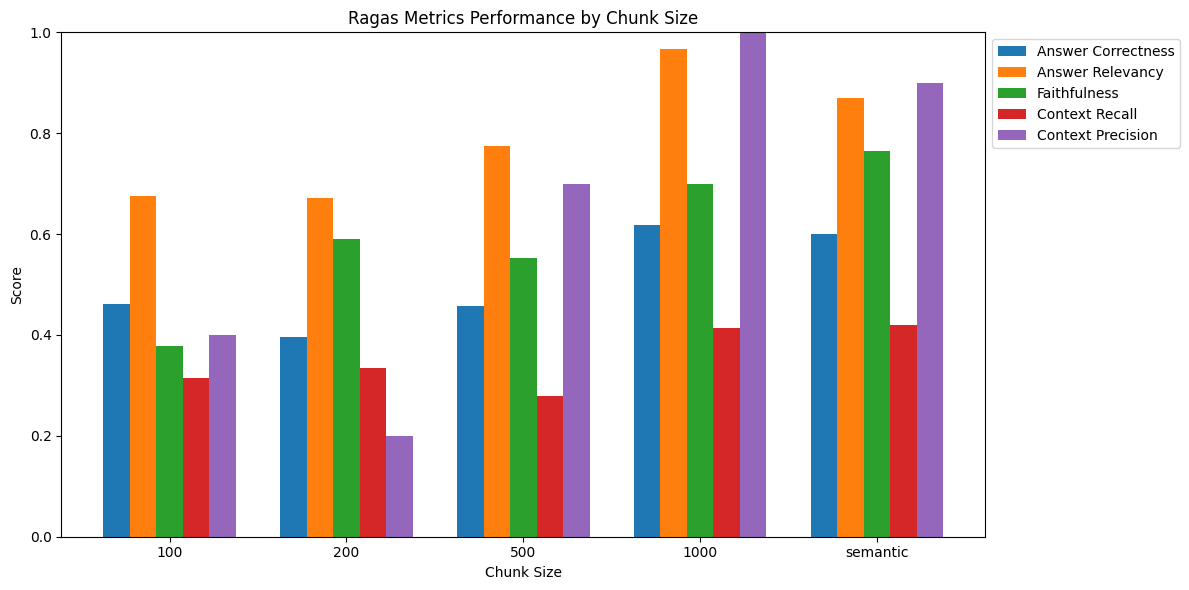

In [12]:
# Setting up the plot
fig, ax = plt.subplots(figsize = (12, 6))

# Getting the metrics and their display names
metrics = ['answer_correctness', 'answer_relevancy', 'faithfulness', 'context_recall', 'context_precision']
metric_display_names = ['Answer Correctness', 'Answer Relevancy', 'Faithfulness', 'Context Recall', 'Context Precision']

# Setting up the x-axis
x = range(len(df_chunking_results['chunk_size']))
width = 0.15

# Plotting each metric
for i, (metric, display_name) in enumerate(zip(metrics, metric_display_names)):
    ax.bar([xi + i * width for xi in x], df_chunking_results[metric], width, label = display_name)

# Customizing the plot
ax.set_ylabel('Score')
ax.set_title('Ragas Metrics Performance by Chunk Size')
ax.set_xticks([xi + width * 2 for xi in x])
ax.set_xticklabels(df_chunking_results['chunk_size'])
ax.set_xlabel('Chunk Size')
ax.legend(loc = 'upper left', bbox_to_anchor = (1, 1))

# Setting y-axis limit to 1.0
ax.set_ylim(0, 1.0)

# Adjusting layout and displaying the plot
plt.tight_layout()
plt.show()




In [13]:
# Saving the results to file
df_chunking_results.to_csv('../data/chunking_experiment_results.csv', index = False)

# Optimized Indexing for Fast Retrieval
Now that we have covered the chunking strategies, let's move into talking about indexing. To be completely transparent, I struggled to emulate this because pretty much all vector databases come with some sort of indexing algorithm built in! Most commonly, you will run into a particular algorithm called **Hierarchical Navigable Small World (HNSW)**. While there are indeed other options for indexing, we won't necessarily cover those. Again, this is because whether you choose to use Pinecone, Weaviate, AWS OpenSearch, Chroma, FAISS, or one of the other multitude of options out there, you're going to get this indexing optimization built in.

Instead, what we'll focus on is comparing retrieval speeds between an index with no special optimizations applied compared to the FAISS in-memory database option that we used in the previous chunking section.

In [14]:
# Loading the documents
documents = DataFrameLoader(df_kis, page_content_column = 'ki_text').load()

# Creating FAISS index without chunking
faiss_index = FAISS.from_documents(documents, embedding_algorithm)

# Printing the number of items in FAISS index
print(f"Number of items in FAISS index: {faiss_index.index.ntotal}")


Number of items in FAISS index: 100


In [15]:
# Creating a standard Python list to store embeddings
standard_list_embeddings = []

# Embedding documents and storing in the list
for doc in documents:
    embedding = embedding_algorithm.embed_query(doc.page_content)
    standard_list_embeddings.append(embedding)

# Printing the length of the list to confirm
print(f"Number of embeddings in standard list: {len(standard_list_embeddings)}")

Number of embeddings in standard list: 100


In [16]:
def find_most_similar(query_embedding, embeddings_list):
    similarities = [np.dot(query_embedding, doc_embedding) for doc_embedding in embeddings_list]
    return np.argmax(similarities)

faiss_times = []
standard_times = []

for question in df_validation['question']:
    # FAISS retrieval
    start_time = time.time()
    faiss_index.similarity_search(question, k = 1)
    faiss_times.append(time.time() - start_time)
    
    # Standard list retrieval
    start_time = time.time()
    query_embedding = embedding_algorithm.embed_query(question)
    find_most_similar(query_embedding, standard_list_embeddings)
    standard_times.append(time.time() - start_time)

print(f"Average FAISS retrieval time: {sum(faiss_times) / len(faiss_times):.6f} seconds")
print(f"Average standard list retrieval time: {sum(standard_times) / len(standard_times):.6f} seconds")


Average FAISS retrieval time: 0.144013 seconds
Average standard list retrieval time: 0.178085 seconds


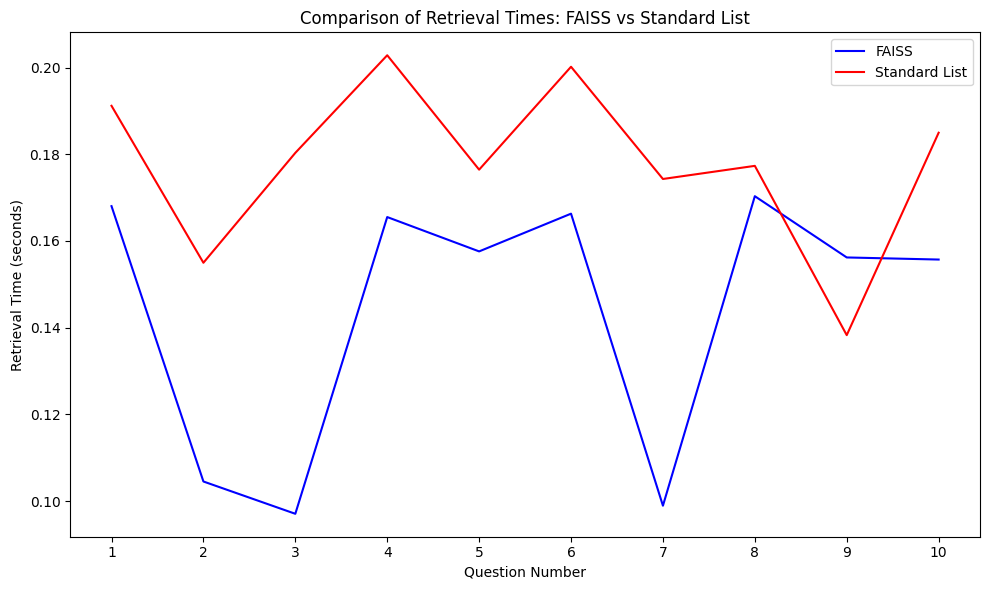

In [17]:
import matplotlib.pyplot as plt

# Creating data for the plot
methods = ['FAISS', 'Standard List']
questions = range(1, 11)  # Assuming 10 questions

# Creating the line plot
plt.figure(figsize = (10, 6))
plt.plot(questions, faiss_times[:10], 'b-', label = 'FAISS')
plt.plot(questions, standard_times[:10], 'r-', label = 'Standard List')

# Adding labels and title
plt.xlabel('Question Number')
plt.ylabel('Retrieval Time (seconds)')
plt.title('Comparison of Retrieval Times: FAISS vs Standard List')
plt.legend()

# Setting x-axis ticks to whole numbers
plt.xticks(questions)

# Displaying the plot
plt.tight_layout()
plt.show()
